In [21]:
import pandas as pd
import numpy as np

# ถ้า notebook อยู่โฟลเดอร์เดียวกับไฟล์
CSV_PATH = "csi_dataset_cleaned.csv"

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:20], "...")

Shape: (3133, 61)
Columns: ['timestamp', 'label', 'rssi', 'noise_floor', 'channel', 'fft_gain', 'agc_gain', 'amp_0', 'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11', 'amp_12'] ...


In [22]:
# เลือกเฉพาะคอลัมน์ที่เป็น amplitude
feature_cols = [c for c in df.columns if c.startswith("amp_")]

print("Number of amp features:", len(feature_cols))
print("Example:", feature_cols[:10])

# ยืนยันว่ามี label
assert "label" in df.columns, "label column not found!"

Number of amp features: 53
Example: ['amp_0', 'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9']


In [23]:
# Hyperparameters for windowing
WINDOW_SIZE = 64   # length of each window (number of rows/time steps)
STRIDE      = 32    # step size between windows

print("WINDOW_SIZE:", WINDOW_SIZE)
print("STRIDE     :", STRIDE)

WINDOW_SIZE: 64
STRIDE     : 32


In [24]:
def window_label_rule(labels_window: np.ndarray) -> int:
    """
    รับ array ของ label ใน window หนึ่งช่วง
    คืน label ของทั้ง window ตาม priority:
      2 (movement) > 1 (human_static) > 0 (no_human)
    """
    if np.any(labels_window == 2):
        return 2
    elif np.any(labels_window == 1):
        return 1
    else:
        return 0

In [25]:
def create_windows_from_df(
    df: pd.DataFrame,
    feature_cols,
    window_size: int,
    stride: int,
    label_col: str = "label",
    group_col: str | None = "source_file"
):
    """
    สร้าง time windows จาก DataFrame

    Returns:
        X_windows: np.ndarray (N_windows, window_size, n_features)
        y_windows: np.ndarray (N_windows,)
        meta: list of (group_name, start_idx, end_idx)
    """
    X_list = []
    y_list = []
    meta  = []

    # ถ้าไม่มี group_col ใช้ทั้ง df เป็น sequence เดียว
    if group_col is None or group_col not in df.columns:
        groups = [(None, df)]
    else:
        groups = df.groupby(group_col)

    for gname, gdf in groups:
        # เรียงตามเวลา ถ้ามี timestamp
        if "timestamp" in gdf.columns:
            gdf = gdf.sort_values("timestamp")
        else:
            gdf = gdf.sort_index()

        data = gdf[feature_cols].values.astype(np.float32)
        labels = gdf[label_col].values.astype(np.int64)
        T = len(gdf)

        if T < window_size:
            # sequence สั้นเกินไป ข้าม
            continue

        for start in range(0, T - window_size + 1, stride):
            end = start + window_size

            x_win = data[start:end]             # (window_size, n_features)
            y_win = window_label_rule(labels[start:end])

            X_list.append(x_win)
            y_list.append(y_win)
            meta.append((gname, start, end))

    X_windows = np.stack(X_list) if X_list else np.empty((0, window_size, len(feature_cols)))
    y_windows = np.array(y_list, dtype=np.int64)

    return X_windows, y_windows, meta

In [26]:
X_win, y_win, meta = create_windows_from_df(
    df,
    feature_cols=feature_cols,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    label_col="label",
    group_col="source_file"  # ถ้า df ไม่มี column นี้ เปลี่ยนเป็น None
)

print("X_win shape:", X_win.shape)  # (N_windows, WINDOW_SIZE, n_features)
print("y_win shape:", y_win.shape)

# ดู distribution ของ label หลัง windowing
unique, counts = np.unique(y_win, return_counts=True)
print("Window labels distribution:")
for u, c in zip(unique, counts):
    print(f"  label {u}: {c}")

X_win shape: (74, 64, 53)
y_win shape: (74,)
Window labels distribution:
  label 0: 6
  label 1: 36
  label 2: 32


In [27]:
idx = 0  # ลองเปลี่ยน index ดู
print("Window index:", idx)
print("Label:", y_win[idx])
print("Shape:", X_win[idx].shape)  # (WINDOW_SIZE, n_features)

Window index: 0
Label: 0
Shape: (64, 53)


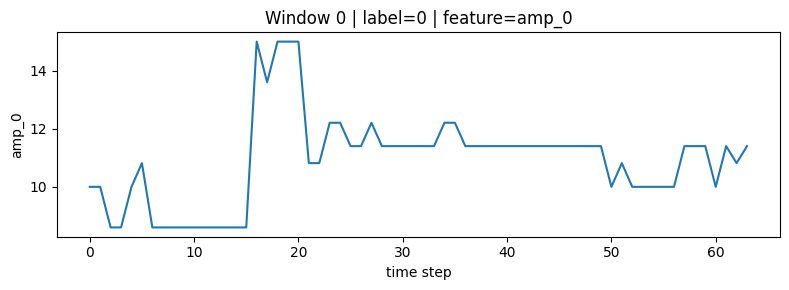

In [28]:
import matplotlib.pyplot as plt

def plot_window_example(idx, amp_index=0):
    """
    แสดงกราฟของ window ที่เลือก สำหรับ subcarrier ที่เลือก (amp_index)
    """
    window = X_win[idx]  # (T, C)
    t = np.arange(window.shape[0])
    plt.figure(figsize=(8,3))
    plt.plot(t, window[:, amp_index])
    plt.title(f"Window {idx} | label={y_win[idx]} | feature=amp_{amp_index}")
    plt.xlabel("time step")
    plt.ylabel(f"amp_{amp_index}")
    plt.tight_layout()
    plt.show()

plot_window_example(0, amp_index=0)

In [29]:
import os

os.makedirs("windows", exist_ok=True)

np.save("windows/X_win.npy", X_win)
np.save("windows/y_win.npy", y_win)

print("✅ Saved:")
print("  windows/X_win.npy")
print("  windows/y_win.npy")

✅ Saved:
  windows/X_win.npy
  windows/y_win.npy


In [30]:
# ดูว่าภายใน window มี label อะไรบ้าง
def inspect_window(idx):
    gname, start, end = meta[idx]
    print("Window label:", y_win[idx])
    print("Labels inside window:", np.unique(
        df[df["source_file"] == gname]["label"].values[start:end]
    ))

inspect_window(0)

Window label: 0
Labels inside window: [0]


In [31]:
import numpy as np

unique, counts = np.unique(y_win, return_counts=True)
print("Window class distribution:")
for u, c in zip(unique, counts):
    print(f"  class {u}: {c}")

Window class distribution:
  class 0: 6
  class 1: 36
  class 2: 32
